In [1]:
import os
os.chdir('..')

In [2]:
# import pandas as pd
import numpy as np
# import scipy
import matplotlib.pyplot as plt
from sklearn import impute, preprocessing, model_selection, base, metrics, linear_model, pipeline, ensemble, svm, multiclass, neighbors, compose, datasets, decomposition, manifold
import tensorflow as tf
from tensorflow import keras
# import tensorflow_datasets as tfds
# import cv2
from custom_objects import decorators

2024-10-30 15:32:51.923027: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 15:32:52.007999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730316772.041317    4020 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730316772.050951    4020 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 15:32:52.132924: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
cifar10 = keras.datasets.cifar10.load_data()

(X_train, y_train), (X_test, y_test) = (cifar10[0][0], cifar10[0][1]), (cifar10[1][0], cifar10[1][1])

In [5]:
X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [6]:
X_valid, y_valid = X_train[40000:], y_train[40000:]
X_train, y_train = X_train[:40000], y_train[:40000]

In [7]:
def plot_classes(X, y=None, rows=2, columns=5, class_names=None):
    fig, axes = plt.subplots(rows, columns, figsize=(10,4))
    if y is None:
        classes = list(range(0,9))
    else:
        y = y.reshape(-1,)
        classes = np.unique(y)
    if class_names is None:
        class_names = classes
    for class_name, class_, axis in zip(class_names, classes, axes.flat):
        image = X[y==class_][0]
        axis.imshow(image)
        axis.set_title(class_)
        axis.axis('off')

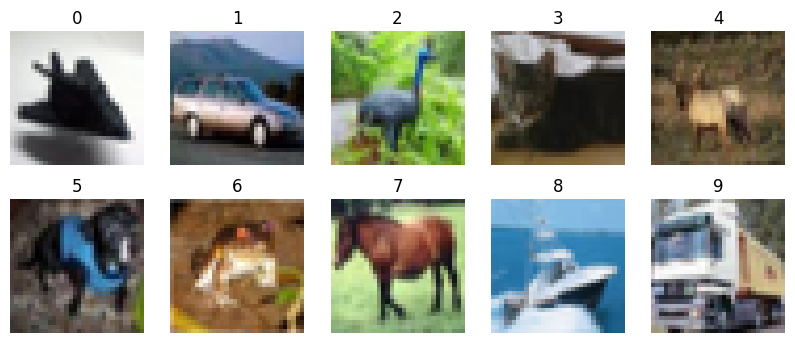

In [8]:
plot_classes(X_train, y_train)

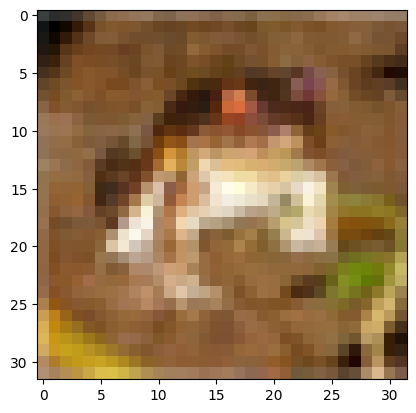

In [9]:
plt.imshow(X_train[0])

**MODEL**

I have created a Sequential Model with 20 hidden layers, each contains 100 neurons. The _activation function_ used is **ELU** with **He Normal** _kernel initialization_.
The output layer use **softmax** _activation function_ for 10 classes.

In [10]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
 
hidden = []

for i in range(20):
    hidden.append(keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'))

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(32,32,3)),
    keras.layers.Flatten(),
    *hidden,
    keras.layers.Dense(10, activation='softmax')
])

/home/thory/miniconda3/envs/tiny-ml/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1730316774.560229    4020 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9739 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [12]:
import os
root_logdir = os.path.join(os.curdir, 'my_logs')

def get_run_logdir():
    import time
    run_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return os.path.join(root_logdir, run_id)

**COMPILING AND TRAINING**

I have used **Nadam** optimizer with a _learning rate = 0.0005_. I also have used a **Performance Scheduler** as the _learning rate schedule_ which reduces my learning rate to 3/4 everytime the model's validation loss does not improve for 10 epochs. The loss and metrics used are too obvious to explain.

Along with this, I use two callbacks - **Early stopping** with a patience of 10, and **Tensorboard** for visualizing learning curves.
We will run for 100 epochs and leave it to the Early Stopping callback to stop training and return the best weights.

In [13]:
   
optimizer = keras.optimizers.Nadam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

run_logdir = get_run_logdir()
tensorboard = keras.callbacks.TensorBoard(log_dir=run_logdir)
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [28]:

# RTX 4070 Ti Before Repair   
model.fit(X_train, y_train, epochs=4, callbacks=[early_stopping, tensorboard], validation_split=0.2)

Epoch 1/4
1000/1000 [==============================] - 7s 7ms/step - loss: 1.8149 - accuracy: 0.3334 - val_loss: 1.7954 - val_accuracy: 0.3392
Epoch 2/4
1000/1000 [==============================] - 7s 7ms/step - loss: 1.7827 - accuracy: 0.3507 - val_loss: 1.7867 - val_accuracy: 0.3462
Epoch 3/4
1000/1000 [==============================] - 7s 7ms/step - loss: 1.7532 - accuracy: 0.3615 - val_loss: 1.7715 - val_accuracy: 0.3514
Epoch 4/4
1000/1000 [==============================] - 6s 6ms/step - loss: 1.7398 - accuracy: 0.3663 - val_loss: 1.7470 - val_accuracy: 0.3627


In [15]:

# RTX 4070 Ti After Second Repair   
model.fit(X_train, y_train, epochs=4, batch_size=264, callbacks=[early_stopping, tensorboard], validation_split=0.2)

Epoch 1/4


2024-10-30 13:57:56.815682: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2455', 288 bytes spill stores, 408 bytes spill loads



122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3828 - loss: 1.7091 - val_accuracy: 0.3821 - val_loss: 1.6910
Epoch 2/4
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4014 - loss: 1.6493 - val_accuracy: 0.3911 - val_loss: 1.6765
Epoch 3/4
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4129 - loss: 1.6154 - val_accuracy: 0.3850 - val_loss: 1.6991
Epoch 4/4
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4205 - loss: 1.5976 - val_accuracy: 0.4038 - val_loss: 1.6576


In [16]:

# RTX 4070 Ti After Second Repair  and Security Updates 
model.fit(X_train, y_train, epochs=4, batch_size=128, callbacks=[early_stopping, tensorboard], validation_split=0.2)

Epoch 1/4
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3143 - loss: 1.8955 - val_accuracy: 0.3351 - val_loss: 1.8517
Epoch 2/4
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3355 - loss: 1.8237 - val_accuracy: 0.3526 - val_loss: 1.8096
Epoch 3/4
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3628 - loss: 1.7686 - val_accuracy: 0.3551 - val_loss: 1.7919
Epoch 4/4
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3743 - loss: 1.7222 - val_accuracy: 0.3491 - val_loss: 1.7894


In [14]:
# RTX 4070 Ti After Repair   
model.fit(X_train, y_train, epochs=4, callbacks=[early_stopping, tensorboard], validation_split=0.2)

Epoch 1/4


I0000 00:00:1730289230.378715   19913 service.cc:148] XLA service 0x739c34002760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730289230.378733   19913 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2024-10-30 07:53:50.483501: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730289230.575439   19913 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-10-30 07:53:50.630486: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


 111/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1151 - loss: 26.6589

I0000 00:00:1730289231.114342   19913 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.1613 - loss: 6.5502 - val_accuracy: 0.2194 - val_loss: 2.0988
Epoch 2/4
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2572 - loss: 1.9942 - val_accuracy: 0.2767 - val_loss: 1.9537
Epoch 3/4
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3000 - loss: 1.9077 - val_accuracy: 0.2811 - val_loss: 1.9237
Epoch 4/4
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3169 - loss: 1.8616 - val_accuracy: 0.2968 - val_loss: 1.9042


In [16]:
# RTX 4070 Ti After Repair   Rerun
model.fit(X_train, y_train, epochs=4, batch_size=128, callbacks=[early_stopping, tensorboard], validation_split=0.2)

Epoch 1/4
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3959 - loss: 1.6453 - val_accuracy: 0.4019 - val_loss: 1.6619
Epoch 2/4
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4204 - loss: 1.6051 - val_accuracy: 0.4081 - val_loss: 1.6514
Epoch 3/4
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4228 - loss: 1.5915 - val_accuracy: 0.4047 - val_loss: 1.6541
Epoch 4/4
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4257 - loss: 1.5733 - val_accuracy: 0.3985 - val_loss: 1.6706


In [31]:
# RTX 4070 Ti After Repair   Rerun
model.fit(X_train, y_train, epochs=4, batch_size=128, callbacks=[early_stopping, tensorboard], validation_split=0.2)

Epoch 1/4
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3749 - loss: 1.7279 - val_accuracy: 0.3785 - val_loss: 1.7197
Epoch 2/4
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3908 - loss: 1.6662 - val_accuracy: 0.3731 - val_loss: 1.7237
Epoch 3/4
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3988 - loss: 1.6507 - val_accuracy: 0.3779 - val_loss: 1.7124
Epoch 4/4
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4105 - loss: 1.6290 - val_accuracy: 0.3796 - val_loss: 1.6919


In [16]:
print(model.evaluate(X_valid, y_valid))

313/313 [==============================] - 0s 1ms/step - loss: 1.8431 - accuracy: 0.3262
[1.8430570363998413, 0.326200008392334]


In [16]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Launching TensorBoard...

![Adam Optimizer](./images/adam_0005_small.png)

Learning Curve for the above run

Let us try **Batch Normalization**

In [18]:
tf.random.set_seed(42)

model_bn = tf.keras.Sequential()
model_bn.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model_bn.add(tf.keras.layers.Dense(100, kernel_initializer="he_normal"))
    model_bn.add(tf.keras.layers.BatchNormalization())
    model_bn.add(tf.keras.layers.Activation("swish"))

model_bn.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model_bn.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='my_logs/model_checkpoints/model_bn.keras', save_best_only=True)

In [21]:
# Before Repair
history = model_bn.fit(X_train, y_train, epochs=9,validation_split=0.3 , callbacks=[early_stopping_cb, tensorboard, model_checkpoint_cb])

Epoch 1/100
875/875 [==============================] - 52s 51ms/step - loss: 2.1278 - accuracy: 0.2117 - val_loss: 2.0745 - val_accuracy: 0.2428
Epoch 2/100
875/875 [==============================] - 95s 108ms/step - loss: 1.8676 - accuracy: 0.3192 - val_loss: 2.0983 - val_accuracy: 0.2508
Epoch 3/100
875/875 [==============================] - 145s 165ms/step - loss: 1.7570 - accuracy: 0.3685 - val_loss: 1.8977 - val_accuracy: 0.3205
Epoch 4/100
875/875 [==============================] - 122s 139ms/step - loss: 1.6821 - accuracy: 0.3963 - val_loss: 1.7904 - val_accuracy: 0.3583
Epoch 5/100
875/875 [==============================] - 118s 134ms/step - loss: 1.6226 - accuracy: 0.4231 - val_loss: 1.9626 - val_accuracy: 0.3338
Epoch 6/100
875/875 [==============================] - 121s 139ms/step - loss: 1.5812 - accuracy: 0.4363 - val_loss: 1.6882 - val_accuracy: 0.4024
Epoch 7/100
875/875 [==============================] - 136s 156ms/step - loss: 1.5398 - accuracy: 0.4525 - val_loss: 1.67


KeyboardInterrupt



In [19]:
# After Repair
history = model_bn.fit(X_train, y_train, epochs=9,validation_split=0.3 , callbacks=[early_stopping_cb, tensorboard, model_checkpoint_cb])

Epoch 1/9
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.1586 - loss: 2.2853 - val_accuracy: 0.2737 - val_loss: 2.0946
Epoch 2/9
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3062 - loss: 1.9018 - val_accuracy: 0.3186 - val_loss: 1.9431
Epoch 3/9
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3678 - loss: 1.7529 - val_accuracy: 0.3317 - val_loss: 1.8763
Epoch 4/9
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4070 - loss: 1.6584 - val_accuracy: 0.3184 - val_loss: 2.0354
Epoch 5/9
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4456 - loss: 1.5807 - val_accuracy: 0.3397 - val_loss: 1.8760
Epoch 6/9
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4631 - loss: 1.5142 - val_accuracy: 0.3424 - val_loss: 1.9161
Epoch 7/9
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4904 - loss: 1.4471 - val_accuracy: 0.3722 - val_loss: 1.8241
Epoch 8/9
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5094 - loss: 1.3839 - val_accuracy: 0.3608 - v

In [21]:
# After Repair with batched
history = model_bn.fit(X_train, y_train, batch_size=32, epochs=9,validation_split=0.3 , callbacks=[early_stopping_cb, tensorboard, model_checkpoint_cb])

Epoch 1/9
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5117 - loss: 1.3889 - val_accuracy: 0.3729 - val_loss: 1.8293
Epoch 2/9
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5368 - loss: 1.3275 - val_accuracy: 0.3558 - val_loss: 1.9557
Epoch 3/9
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5588 - loss: 1.2574 - val_accuracy: 0.3566 - val_loss: 2.0648
Epoch 4/9
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5825 - loss: 1.1949 - val_accuracy: 0.3677 - val_loss: 1.9602
Epoch 5/9
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6035 - loss: 1.1415 - val_accuracy: 0.3528 - val_loss: 2.0722
Epoch 6/9
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6256 - loss: 1.0882 - val_accuracy: 0.3334 - val_loss: 2.2143
Epoch 7/9
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6371 - loss: 1.0441 - val_accuracy: 0.3528 - val_loss: 2.1524
Epoch 8/9
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6478 - loss: 1.0048 - val_accuracy: 0.3413 - v

In [129]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_selu_model", save_best_only=True)

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 32*32*3)).reshape(-1, 32,32,3)

history_2 = model.fit(X_train_scaled, y_train, epochs=100,
          validation_split=0.3,
          callbacks=callbacks)

ValueError: Data cardinality is ambiguous:
  x sizes: 10000
  y sizes: 50000
Make sure all arrays contain the same number of samples.